# Nifty 50 Partial Replication

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
def tracking_error(y_true, y_pred):
    # Convert y_true and y_pred to pandas Series for easy handling of pct_change()
    y_true = pd.Series(y_true)
    y_pred = pd.Series(y_pred)
    
    # Calculate percentage change for true values and predictions
    pct_change_true = y_true.pct_change() * 100
    pct_change_pred = y_pred.pct_change() * 100
    
    # Calculate the difference between the percentage changes
    diff_pct_change = pct_change_true - pct_change_pred    
    
    # Return the standard deviation of the differences (tracking error)
    return np.std(diff_pct_change.dropna())  # dropna() to avoid NaN values in pct_change

## Data

In [3]:
# directory_path = '/kaggle/input/stock-market-data-nifty-50-stocks-1-min-data'
# pattern = os.path.join(directory_path, "*.csv")  # Change "*.csv" to match other patterns if needed

# Get the list of files that match the pattern
# file_list = glob.glob(pattern)

In [4]:
def fetch_data(cols):
    df_list = []
    for file in tqdm(file_list):
        stock_name = os.path.basename(file).split("_")[0]
        file_df = pd.read_csv(file, index_col=0)
        file_df = file_df[[cols]]
        file_df.columns = pd.MultiIndex.from_product([[stock_name], file_df.columns])
        df_list.append(file_df)
    return pd.concat(df_list, axis=1)

In [5]:
# df = fetch_data('close')
# df.to_csv('/kaggle/input/nifty_50_closing.csv')

In [6]:
df = pd.read_csv('/kaggle/input/nifty-50-closing-data/nifty_50_closing.csv', index_col=0, header=[0, 1])
df = df.xs('close', level=1, axis=1)
df.index = pd.to_datetime(df.index)

In [7]:
nifty_100_closing = pd.read_csv('/kaggle/input/nifty-50-minute-data/NIFTY 100_minute.csv', index_col=0)[['close']]
nifty_100_closing.index = pd.to_datetime(nifty_100_closing.index)
nifty_100_closing.rename(columns={'close': 'NIFTY_100'}, inplace=True)

In [8]:
print(f"Index type for df1: {type(df.index)}")
print(f"Index type for df2: {type(nifty_100_closing.index)}")

Index type for df1: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type for df2: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [9]:
# df.interpolate(method='linear', inplace=True)
# To fill the first row NaN with the value from the next minute
df.fillna(0, inplace=True)
df.index = df.index.tz_localize(None)
df.head(3)

,HDFCAMC,APOLLOHOSP,BOSCHLTD,INDUSTOWER,BERGEPAINT,MARICO,ICICIPRULI,HDFCLIFE,SBIN,SUNPHARMA,...,SBICARD,DABUR,SAIL,BRITANNIA,ADANIPORTS,ONGC,EICHERMOT,TECHM,JINDALSTEL,HEROMOTOCO
date,,,,,,,,,,,,,,,,,,,,,
2018-08-06 10:47:00,1803.95,974.3,19187.45,290.0,316.85,357.95,408.50,485.00,306.70,579.65,...,0.0,435.30,79.35,3194.92,400.70,167.75,2711.3,670.45,207.65,3259.0
2018-08-06 10:48:00,1803.90,973.7,19187.45,290.0,316.50,357.55,408.10,484.95,306.70,579.30,...,0.0,435.15,79.30,3193.02,400.55,167.55,2710.6,670.55,207.80,3260.6
2018-08-06 10:49:00,1806.00,973.7,19187.45,290.0,316.85,357.20,408.85,485.00,306.75,579.45,...,0.0,435.70,79.30,3192.50,400.30,167.55,2709.8,670.65,207.55,3259.5


In [10]:
df_total = df.join(nifty_100_closing, how='left')

In [11]:
df_total.dropna(inplace=True)

# Models

# Lasso Regression

In [12]:
def train_lasso(alpha, tscv, X, y):
    lasso = Lasso(alpha=alpha, max_iter=30000)
    scores = []
    coefficients = []
    
    for train_index, test_index in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
        
        # Fit Lasso model on the training data
        lasso.fit(X_train_cv, y_train_cv)
        
        # Append the coefficients for this fold
        coefficients.append(lasso.coef_)
        
        # Get predictions and calculate the custom score for this fold
        y_pred = lasso.predict(X_test_cv)
        fold_score = tracking_error(y_test_cv.values, y_pred)  # Replace with your custom metric
        print(f"Fold Score {fold_score}")
        scores.append(fold_score)
    
    # Calculate the average coefficients across all folds
    average_coefficients = np.mean(coefficients, axis=0)
    
    # Calculate the average score across all folds
    average_score = np.mean(scores)

    print(f"-------alpha: {alpha}-------")
    print(f"CV Score: {average_score}")
    
    selected_stocks = np.where(abs(average_coefficients) > 1e-5)[0]

    return (selected_stocks, average_score)

Fold Score 0.014591880126020274
Fold Score 0.3572804332574863
Fold Score 1.1071145499001587
-------alpha: 5-------
CV Score: 0.49299562109455514
Fold Score 0.012519136774740092
Fold Score 0.38971862950613695
Fold Score 1.0963922347445962
-------alpha: 10-------
CV Score: 0.4995433336751578
Fold Score 0.012109612050293287
Fold Score 0.335946583397948
Fold Score 0.9913390272992725
-------alpha: 25-------
CV Score: 0.4464650742491712
Fold Score 0.013060651526248964
Fold Score 0.3118773907288767
Fold Score 0.8211651986960208
-------alpha: 50-------
CV Score: 0.38203441365038215
Fold Score 0.014571130721140066
Fold Score 0.29849463693694117
Fold Score 0.776845445854182
-------alpha: 75-------
CV Score: 0.3633037378374211
Fold Score 0.01618813168093935
Fold Score 0.29355792024500466
Fold Score 0.7552486845876754
-------alpha: 100-------
CV Score: 0.3549982455045398


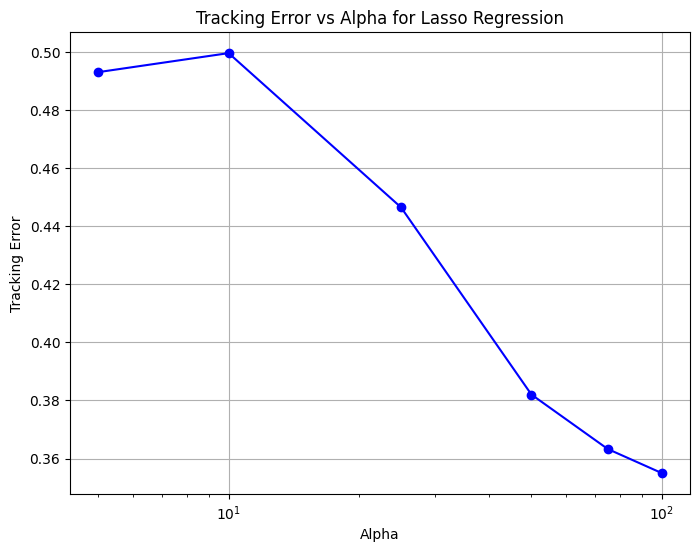

In [13]:
X = df_total.drop(columns=['NIFTY 50', 'NIFTY BANK', 'NIFTY_100'])
y = df_total['NIFTY_100']

# TimeSeriesSplit to conserve the order of the data
tscv = TimeSeriesSplit(n_splits=3)

alphas = [5, 10, 25, 50, 75, 100]
tracking_errs = []
chosen_stocks = []
for alpha in alphas:
    (stocks, err) = train_lasso(alpha, tscv, X, y)
    tracking_errs.append(err)
    chosen_stocks.append(stocks)

plt.figure(figsize=(8, 6))
plt.plot(alphas, tracking_errs, marker='o', linestyle='-', color='b')
plt.xscale('log')  # Use logarithmic scale for alpha
plt.xlabel('Alpha')
plt.ylabel('Tracking Error')
plt.title('Tracking Error vs Alpha for Lasso Regression')
plt.grid(True)
plt.show()

# Random Forest